<a href="https://colab.research.google.com/github/afzal442/TimeSeriesAnalysysofCovid-19inIndia/blob/main/TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12

In [ ]:
confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed = confirmed_cases.drop(['Province/State','Country/Region','Lat','Long'] , axis = 1)
dates = confirmed.keys()
india_cases = []
for i in dates:
    confirmed_sum = confirmed[i].sum()
    india_cases.append(confirmed_cases[confirmed_cases['Country/Region']=='India'][i].sum())
india_cases = np.array(india_cases).reshape(-1, 1)

In [ ]:
df = pd.DataFrame(index=dates, columns=['confirmed_cases'])
df["confirmed_cases"] = india_cases

In [ ]:
df.tail()

,confirmed_cases
6/18/21,29823546
6/19/21,29881772
6/20/21,29935221
6/21/21,29977861
6/22/21,30028709


**LSTM Model**

In [ ]:
df_data = df['confirmed_cases'].values
df_data = df_data.reshape((-1,1))

n_percent = 0.80
s = int(n_percent*len(df_data))

df_train = df_data[:s]
df_test = df_data[s:]

date_train = df.index[:s]
date_test = df.index[s:]

In [ ]:
train_generator = TimeseriesGenerator(df_train, df_train, length=5, batch_size=10)     
test_generator = TimeseriesGenerator(df_test, df_test, length=5, batch_size=10)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation 

model = Sequential()
model.add(
    LSTM(128,
        activation='relu',
        input_shape=(5,1))
)
#model.add(Dropout(0.2))


model.add(Dense(1))
#model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

num_epochs = 80
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/80
41/41 [==============================] - 23s 6ms/step - loss: 11207506919424.0000 - accuracy: 0.0026
Epoch 2/80
41/41 [==============================] - 0s 7ms/step - loss: 2068365976722.2856 - accuracy: 0.0221
Epoch 3/80
41/41 [==============================] - 0s 7ms/step - loss: 125305482635.8155 - accuracy: 0.0091
Epoch 4/80
41/41 [==============================] - 0s 6ms/step - loss: 3981458613394.2856 - accuracy: 0.0038
Epoch 5/80
41/41 [==============================] - 0s 6ms/step - loss: 456145096886.8571 - accuracy: 0.0107
Epoch 6/80
41/41 [==============================] - 0s 7ms/step - loss: 368262419602.2857 - accuracy: 0.0054
Epoch 7/80
41/41 [==============================] - 0s 6ms/step - loss: 137944648144.7619 - accuracy: 0.0044
Epoch 8/80
41/41 [==============================] - 0s 6ms/step - loss: 104243159137.5238 - accuracy: 0.0203
Epoch 9/80
41/41 [==============================] - 0s 7ms/step - loss: 339159776207.2381 - accuracy: 0.0238
Epoch 10/80
41

In [ ]:
prediction = model.predict_generator(test_generator)

In [ ]:
pred_list = []
n_input = 5
n_features = 1
n_forecast = 10 # forecast future dates

batch = df_data[-n_input:].reshape((1, n_input, n_features))

for i in range(n_forecast):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
prediction_list = []
for item in pred_list:
    prediction_list.append(int(item))
    
def predict_dates(n_forecast):
    l_date = df.index.values[-1]
    post_dates = pd.date_range(l_date, periods=n_forecast).tolist()
    return post_dates


forecast_dates = predict_dates(n_forecast)

In [ ]:
df_predict = pd.DataFrame(index=forecast_dates, columns=['Prediction'])
df_predict["Prediction"] = prediction_list
df.index = pd.to_datetime(df.index)

In [ ]:
df_predict

,Prediction
2021-06-12,29263660
2021-06-13,29326816
2021-06-14,29375458
2021-06-15,29382430
2021-06-16,29379404
2021-06-17,29367742
2021-06-18,29395984
2021-06-19,29409768
2021-06-20,29412578
2021-06-21,29418502


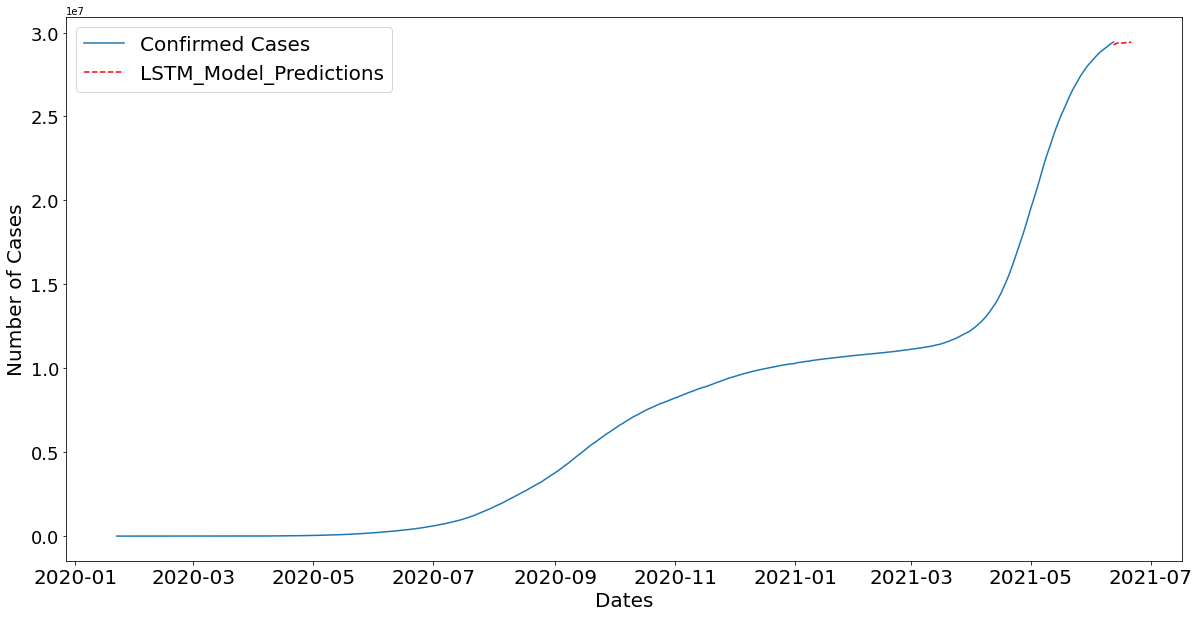

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams["font.family"] = "sans-serif"
plt.plot(df.index, df['confirmed_cases'])
plt.plot(forecast_dates, df_predict["Prediction"],linestyle='dashed', color='r')
plt.legend(['Confirmed Cases', 'LSTM_Model_Predictions'], prop={'size': 20}, fontsize='xx-large')
plt.xlabel('Dates', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
plt.show()

**Fb-prophet Model**

In [ ]:
df1 = pd.DataFrame(index=dates, columns=['ds', 'y'])
df1["y"] = india_cases
df1.index = pd.to_datetime(df1.index)
df1.index.columns = ['ds']
df1['ds'] = df1.index
df2 = df1[['y']]

In [ ]:
from fbprophet import Prophet

#model
m = Prophet()

#fitting the model
m.fit(df1)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#forecast
future = m.make_future_dataframe(periods= 10) 
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
523,2021-06-28,3.250103e+07,3.150477e+07,3.349389e+07
524,2021-06-29,3.270587e+07,3.167884e+07,3.360846e+07
525,2021-06-30,3.293521e+07,3.199403e+07,3.394211e+07
526,2021-07-01,3.314231e+07,3.214670e+07,3.417784e+07
527,2021-07-02,3.335002e+07,3.239928e+07,3.434825e+07


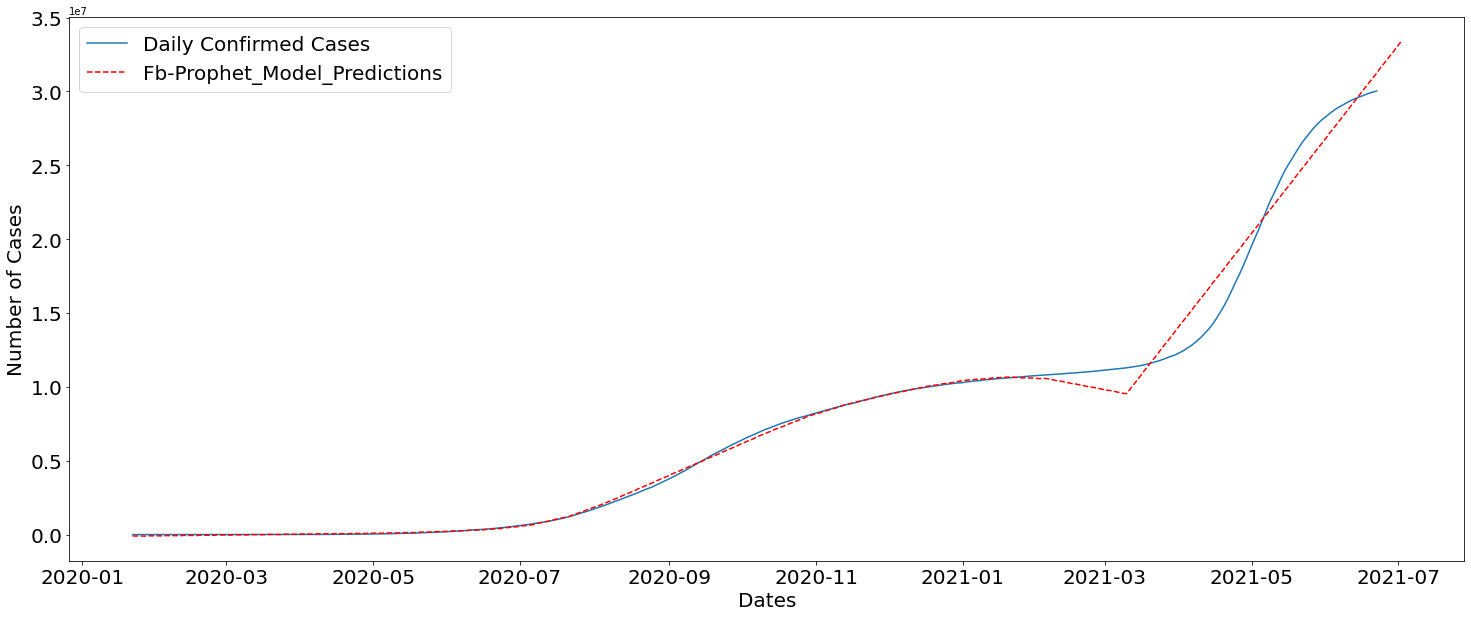

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(df1.index, india_cases)
plt.plot(future, forecast['yhat'],linestyle='dashed', color='r')
plt.legend(['Daily Confirmed Cases', 'Fb-Prophet_Model_Predictions'], prop={'size': 20})
plt.xlabel('Dates', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()